<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/Fuzzy%20Wavelet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal # Для свертки

In [2]:
# --- 1. Определение нечеткой базисной функции (Пример: Треугольная функция) ---
def create_triangular_fuzzy_basis(nodes, support):
    """
    Создает набор треугольных нечетких базисных функций.

    Args:
        nodes (np.array): Массив узлов (x1, x2, ..., xn).
        support (int): Поддержка (ширина) каждой базисной функции.

    Returns:
        list: Список функций (в виде массивов значений) для каждого узла.
    """
    basis_functions = []
    num_nodes = len(nodes)
    # Определяем общий интервал
    a = nodes[0] - support / 2.0
    b = nodes[-1] + support / 2.0
    # Создаем плотную сетку для определения значений функций
    # Увеличиваем плотность для более плавных функций
    grid_points = max(500, int((b-a) * 20))
    x_grid = np.linspace(a, b, grid_points)

    for i, node in enumerate(nodes):
        # Создаем треугольную функцию
        def triangular(x, center, width):
            return np.maximum(0, 1 - np.abs(x - center) / (width / 2.0))

        bf = triangular(x_grid, node, support)
        # Применяем условие 1.2: Ak(x)=0 вне (x_{k-1}, x_{k+1})
        # Это примерное выполнение условия через поддержку
        basis_functions.append(bf)

    return basis_functions, x_grid

# --- 2. Нормализация базисной функции ---
def normalize_basis_function(bf, x_grid):
    """
    Нормализует базисную функцию согласно формуле (6).
    """
    integral = np.trapezoid(bf, x_grid) # Численное интегрирование
    if integral > 0:
        return bf / integral
    else:
        return bf # Избегаем деления на ноль

# --- 3. Fuzzy Transform (Прямое) ---
def fuzzy_transform(signal_values, x_signal, basis_functions, x_grid):
    """
    Вычисляет коэффициенты F-transform для сигнала.

    Args:
        signal_values (np.array): Значения сигнала в точках x_signal.
        x_signal (np.array): Точки, в которых определен сигнал.
        basis_functions (list): Список нормализованных базисных функций.
        x_grid (np.array): Сетка, на которой определены базисные функции.

    Returns:
        list: Список коэффициентов Gk.
    """
    Gk_list = []
    for bf in basis_functions:
        # Интерполируем базисную функцию на сетку сигнала для интегрирования
        bf_interp = np.interp(x_signal, x_grid, bf, left=0, right=0)
        numerator = np.trapezoid(signal_values * bf_interp, x_signal)
        denominator = np.trapezoid(bf_interp, x_signal)
        if denominator > 0:
             Gk = numerator / denominator
        else:
             Gk = 0 # Или другая обработка
        Gk_list.append(Gk)
    return Gk_list

# --- 4. Inverse Fuzzy Transform (Обратное) ---
def inverse_fuzzy_transform(Gk_list, basis_functions, x_grid):
    """
    Восстанавливает сигнал (приближение) из коэффициентов F-transform.
    """
    approx_signal = np.zeros_like(x_grid)
    for Gk, bf in zip(Gk_list, basis_functions):
        approx_signal += Gk * bf
    return approx_signal

# --- 5. Операторы анализа и синтеза Fuzzy Wavelet ---
# --- Определение спектрального сдвига f(n) ---
def spectral_shift_function(length):
    """ Определяет функцию f(n) = (-1)^n """
    return np.array([(-1)**n for n in range(length)])

# --- Дискретная свертка с прореживанием (Decimation) ---
def convolve_and_decimate(signal_data, kernel, decimation_factor=2):
    """
    Выполняет свертку и прореживание.
    Использует scipy.signal.convolve.
    """
    # scipy.signal.convolve: mode='full' -> mode='valid' или 'same' в зависимости от нужд
    # Для соответствия тексту (D(x * A~)), используем 'full' и потом прореживаем
    # ВАЖНО: kernel должен быть в правильном порядке для свертки
    conv_result = signal.convolve(signal_data, kernel, mode='full')
    # Прореживание: оставляем каждый decimation_factor-й элемент, начиная с 0
    # Важно: нужно согласовать индексы с теорией. Простейший способ - начать с 0.
    decimated = conv_result[::decimation_factor]
    return decimated

# --- Интерполяция (Upsampling) ---
def upsample(signal_data, upsampling_factor=2):
    """
    Интерполирует сигнал нулями.
    """
    upsampled = np.zeros(len(signal_data) * upsampling_factor)
    upsampled[::upsampling_factor] = signal_data
    return upsampled

# --- Основная функция Fuzzy Wavelet Analysis (1-й этап) ---
def fuzzy_wavelet_analysis_1st_stage(signal_data, A_tilde, A_tilde_f):
    """
    Выполняет одностадийный анализ Fuzzy Wavelet.

    Args:
        signal (np.array): Входной дискретный сигнал.
        A_tilde (np.array): Отраженная (и нормализованная) базисная функция A.
        A_tilde_f (np.array): Произведение отраженной A и спектрального сдвига f.

    Returns:
        tuple: (low_freq_component, high_freq_component)
    """
    # Вычисление компонент (следуя формулам 66-67, но для дискретного случая)
    # x1 = D(x * A~)
    low_freq = convolve_and_decimate(signal_data, A_tilde, decimation_factor=2)
    # y1 = D(x * A~f)
    high_freq = convolve_and_decimate(signal_data, A_tilde_f, decimation_factor=2)

    return low_freq, high_freq

# --- Основная функция Fuzzy Wavelet Synthesis (1-й этап) ---
def fuzzy_wavelet_synthesis_1st_stage(low_freq, high_freq, A, A_f):
    """
    Выполняет одностадийный синтез Fuzzy Wavelet.

    Args:
        low_freq (np.array): Низкочастотные компоненты.
        high_freq (np.array): Высокочастотные компоненты.
        A (np.array): Базисная функция A.
        A_f (np.array): Произведение A и спектрального сдвига f.

    Returns:
        np.array: Восстановленный (приближенный) сигнал.
    """
    # Интерполяция
    # U(xp)
    upsampled_low = upsample(low_freq, upsampling_factor=2)
    # U(yp)
    upsampled_high = upsample(high_freq, upsampling_factor=2)

    # Свертка и суммирование (следуя формуле 75, но для одномерного случая)
    # xp-1 = U(xp) * A + U(yp) * Af
    # Убедимся, что длины согласуются для свертки. Дополним нулями при необходимости.
    len_needed = len(upsampled_low) + len(A) - 1
    if len(upsampled_high) + len(A_f) - 1 != len_needed:
        print("Warning: Length mismatch after upsampling for synthesis. Padding might be needed.")

    synthesized_low = signal.convolve(upsampled_low, A, mode='full')
    synthesized_high = signal.convolve(upsampled_high, A_f, mode='full')

    # Обрежем до длины synthesized_low (предполагая, что они должны быть одинаковы)
    len_min = min(len(synthesized_low), len(synthesized_high))
    reconstructed_signal = synthesized_low[:len_min] + synthesized_high[:len_min]

    return reconstructed_signal



Начало работы с Fuzzy Wavelet...
Длина исходного сигнала: 512


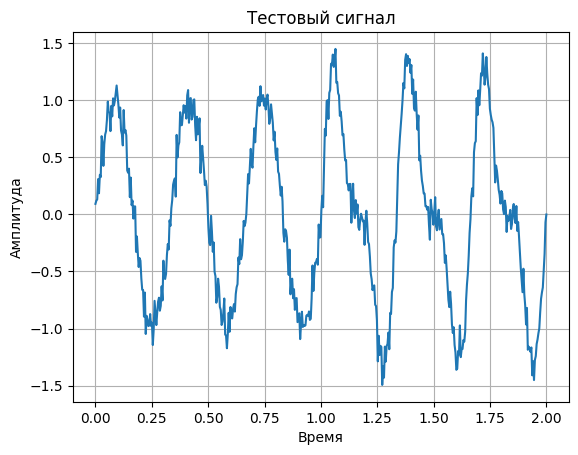

In [10]:
    print("Начало работы с Fuzzy Wavelet...")
    # 1. Создание тестового сигнала
    t = np.linspace(0, 2, 512) # Время
    # Комбинированный сигнал: синусоида + ступенька + шум
    original_signal = np.sin(2 * np.pi * 3 * t) + 0.5 * np.heaviside(t - 1, 1)*np.sin(2 * np.pi * 6 * t) + 0.1 * np.random.randn(len(t))
    print(f"Длина исходного сигнала: {len(original_signal)}")
    plt.plot(t, original_signal)
    plt.title('Тестовый сигнал')
    plt.xlabel('Время')
    plt.ylabel('Амплитуда')
    plt.grid(True)
    plt.show()


In [11]:
    # 2. Определение узлов и базисной функции
    # Узлы должны покрывать интервал сигнала
    num_nodes = 64 # Количество базисных функций
    nodes = np.linspace(t[0], t[-1], num_nodes)
    support = (t[-1] - t[0]) / (num_nodes - 1) * 2 # Ширина поддержки
    print(f"Количество узлов: {num_nodes}, Поддержка: {support}")

    basis_funcs, x_grid_basis = create_triangular_fuzzy_basis(nodes, support)


Количество узлов: 64, Поддержка: 0.06349206349206349


In [12]:

    # 3. Нормализация базисных функций
    normalized_basis_funcs = [normalize_basis_function(bf, x_grid_basis) for bf in basis_funcs]

    # 4. Прямое F-transform (Пример обычного F-transform)
    print("\n--- Пример обычного F-transform ---")
    Gk_coeffs = fuzzy_transform(original_signal, t, normalized_basis_funcs, x_grid_basis)
    approx_signal_ft = inverse_fuzzy_transform(Gk_coeffs, normalized_basis_funcs, x_grid_basis)

    # 5. Подготовка базисных функций для Fuzzy Wavelet
    # Используем первую нормализованную базисную функцию как пример A
    # В реальности нужно выбрать подходящую функцию, удовлетворяющую условиям ортонормированности
    A_example = normalized_basis_funcs[len(normalized_basis_funcs)//2] # Пример из центра
    # Интерполируем A на сетку сигнала t для дискретных операций
    # Используем более плотную сетку для базиса, чтобы интерполяция была точнее
    A_discrete = np.interp(t, np.linspace(x_grid_basis[0], x_grid_basis[-1], len(x_grid_basis)), A_example, left=0, right=0)

    # Отражение A: A~(n) = A(N-n). Для простоты A~(n) = A(-n) при центрировании.
    # Здесь используем зеркальное отражение массива.
    A_tilde_discrete = A_discrete[::-1]

    # Спектральный сдвиг f(n) = (-1)^n
    f_n = spectral_shift_function(len(t))

    # A~f = A~ * f (поэлементное)
    A_tilde_f_discrete = A_tilde_discrete * f_n

    # A_f = A * f
    A_f_discrete = A_discrete * f_n


--- Пример обычного F-transform ---


In [13]:
    low_freq_comp, high_freq_comp = fuzzy_wavelet_analysis_1st_stage(original_signal, A_tilde_discrete, A_tilde_f_discrete)
    # 7. Fuzzy Wavelet Synthesis (1-й этап)
    print("\n--- Одностадийный Fuzzy Wavelet Synthesis ---")
    reconstructed_signal = fuzzy_wavelet_synthesis_1st_stage(low_freq_comp, high_freq_comp, A_discrete, A_f_discrete)
    # Обрезаем восстановленный сигнал до длины оригинала, если нужно
    reconstructed_signal = reconstructed_signal[:len(original_signal)]
    print(f"Длина восстановленного сигнала: {len(reconstructed_signal)}")


--- Одностадийный Fuzzy Wavelet Synthesis ---
Длина восстановленного сигнала: 512


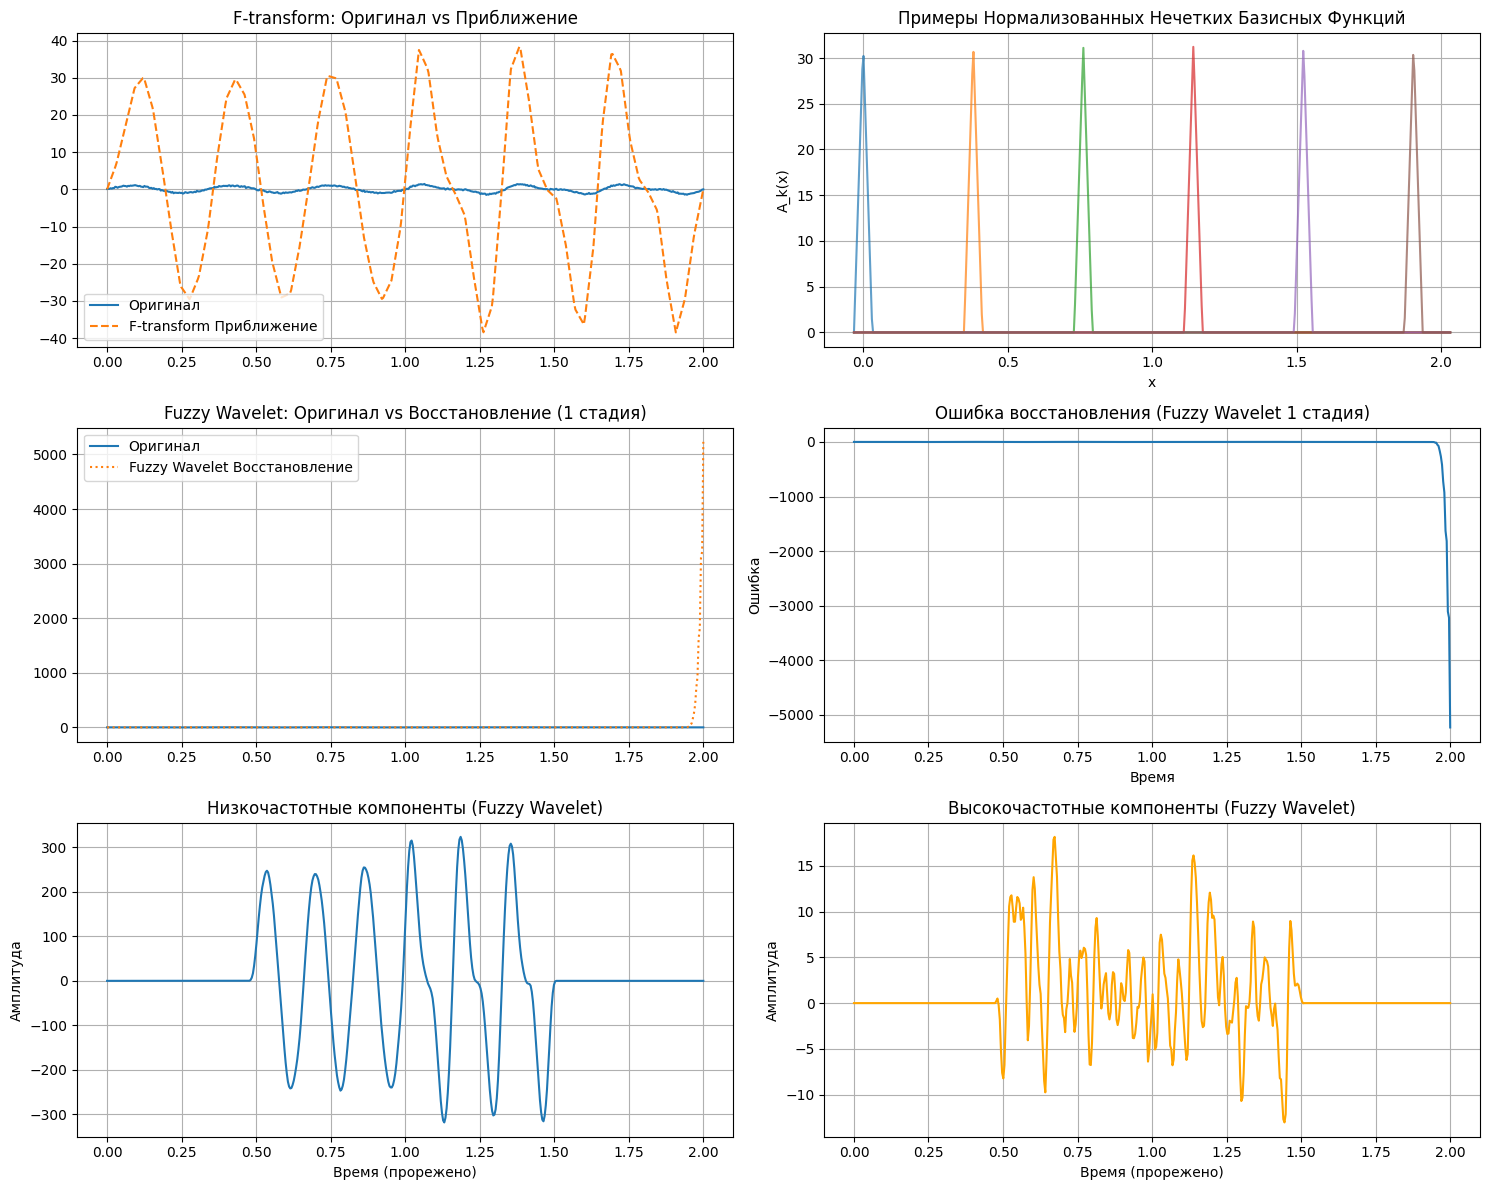


Анализ завершен.


In [15]:
    # 8. Визуализация результатов
    plt.figure(figsize=(15, 12))

    # Исходный и восстановленный сигналы (F-transform)
    plt.subplot(3, 2, 1)
    plt.plot(t, original_signal, label='Оригинал')
    plt.plot(np.linspace(t[0], t[-1], len(approx_signal_ft)), approx_signal_ft, label='F-transform Приближение', linestyle='--')
    plt.title('F-transform: Оригинал vs Приближение')
    plt.legend()
    plt.grid(True)

    # Базисные функции
    plt.subplot(3, 2, 2)
    # Рисуем несколько базисных функций
    step = max(1, len(normalized_basis_funcs)//5)
    indices_to_plot = range(0, len(normalized_basis_funcs), step)
    x_grid_for_plot = np.linspace(x_grid_basis[0], x_grid_basis[-1], len(x_grid_basis))
    for i in indices_to_plot:
        plt.plot(x_grid_for_plot, normalized_basis_funcs[i], alpha=0.7)
    plt.title('Примеры Нормализованных Нечетких Базисных Функций')
    plt.xlabel('x')
    plt.ylabel('A_k(x)')
    plt.grid(True)

    # Исходный и восстановленный сигналы (Fuzzy Wavelet)
    plt.subplot(3, 2, 3)
    plt.plot(t, original_signal, label='Оригинал')
    plt.plot(t[:len(reconstructed_signal)], reconstructed_signal, label='Fuzzy Wavelet Восстановление', linestyle=':')
    plt.title('Fuzzy Wavelet: Оригинал vs Восстановление (1 стадия)')
    plt.legend()
    plt.grid(True)

    # Ошибка восстановления (Fuzzy Wavelet)
    plt.subplot(3, 2, 4)
    # Вычисляем ошибку на той же длине
    len_to_compare = min(len(original_signal), len(reconstructed_signal))
    error = original_signal[:len_to_compare] - reconstructed_signal[:len_to_compare]
    plt.plot(t[:len(error)], error)
    plt.title('Ошибка восстановления (Fuzzy Wavelet 1 стадия)')
    plt.xlabel('Время')
    plt.ylabel('Ошибка')
    plt.grid(True)

    # Low и High частотные компоненты
    plt.subplot(3, 2, 5)
    # Создаем временную шкалу для компонент (с прореживанием)
    t_low = np.linspace(t[0], t[-1], len(low_freq_comp)) # Create time scale based on component length
    plt.plot(t_low, low_freq_comp, label='Low Freq Component')
    plt.title('Низкочастотные компоненты (Fuzzy Wavelet)')
    plt.xlabel('Время (прорежено)')
    plt.ylabel('Амплитуда')
    plt.grid(True)

    plt.subplot(3, 2, 6)
    t_high = np.linspace(t[0], t[-1], len(high_freq_comp)) # Create time scale based on component length
    plt.plot(t_high, high_freq_comp, label='High Freq Component', color='orange')
    plt.title('Высокочастотные компоненты (Fuzzy Wavelet)')
    plt.xlabel('Время (прорежено)')
    plt.ylabel('Амплитуда')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print("\nАнализ завершен.")